In [2]:
import array
import math
import random


class LorenzSystem:
    """The Lorenz system of ordinary differential equations.

    Parameters
    ----------
    x : float
        The current x-coordinate. Default starting value is 0.0.
    y : float
        The current y-coordinate. Default starting value is 1.0.
    z : float
        The current z-coordinate. Default starting value is 1.05.
    sigma : float
        Default value is 10.
        The value of this parameter must be positive.
        It will be clamped to zero if set negative.
    rho : float
        Default value is 28.
        The value of this parameter must be positive.
        It will be clamped to zero if set negative.
    beta : float
        Default value is 8/3.

    Attributes
    ----------
    x, y, z -> float
        The current coordinates.

    Methods
    -------
    take_step -> None
        Take a single step along the trajectory.
    """

    @staticmethod
    def create_lorenz_attractor():
        return LorenzSystem(sigma=10, rho=28, beta=8 / 3)

    @staticmethod
    def create_torus_knot():
        """With ρ = 99.96 it becomes a T(3,2) torus knot."""
        return LorenzSystem(sigma=10, rho=99.96, beta=8 / 3)

    @staticmethod
    def create_stable_system():
        """Create a system that evolves to one of two fixed point attractors."""
        return LorenzSystem(sigma=10, rho=14, beta=8 / 3)

    def __init__(self,
                 x=0.9,
                 y=0,
                 z=0,
                 sigma=10,
                 rho=28,
                 beta=8 / 3,
                 random_factor=None):

        self._x_init = x
        self._y_init = y
        self._z_init = z

        self._random_factor = random_factor

        self._x = None
        self._y = None
        self._z = None
        self.reset()

        self._sigma = sigma
        self._rho = rho
        self._beta = beta

        self._crossed_zero = False

    @property
    def x(self):
        return self._x

    @property
    def x_norm(self):
        return (self._x + 25) / 55

    @property
    def y(self):
        return self._y

    @property
    def y_norm(self):
        return (self._y + 25) / 55

    @property
    def z(self):
        return self._z

    @property
    def z_norm(self):
        return self._z / 55

    @property
    def random_factor(self):
        return self._random_factor

    @random_factor.setter
    def random_factor(self, random_factor):
        self._random_factor = random_factor

    @property
    def crossed_zero(self):
        return self._crossed_zero

    @property
    def coordinates(self):
        return array.array('f', [self._x, self._y, self._z])

    @property
    def initial_coordinates(self):
        return array.array('f', [self._x_init, self._y_init, self._z_init])

    @initial_coordinates.setter
    def initial_coordinates(self, coordinates: array.array):
        self._x_init = coordinates[0]
        self._y_init = coordinates[1]
        self._z_init = coordinates[2]

    def capture_initial_coordinates(self):
        self.initial_coordinates = self.coordinates

    @property
    def convergence_threshold(self):
        """The threshold below which the system is considered converged."""
        return self._convergence_threshold

    @convergence_threshold.setter
    def convergence_threshold(self, convergence_threshold):
        self._convergence_threshold = convergence_threshold

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, sigma):
        if sigma < 0:
            self._sigma = 0
            print("Warning: sigma attempted to go below zero", sigma)
        else:
            self._sigma = sigma

    @property
    def rho(self):
        return self._rho

    @rho.setter
    def rho(self, rho):
        if rho < 0:
            self._rho = 0
            print("Warning: rho attempted to go below zero", rho)
        else:
            self._rho = rho

    @property
    def beta(self):
        return self._beta

    @beta.setter
    def beta(self, beta):
        if beta < 0:
            self._beta = 0
            print("Warning: beta attempted to go below zero", beta)
        else:
            self._beta = beta

    def __compute_derivatives(self, x, y, z):
        dx_dt = self._sigma * (y - x)
        dy_dt = x * (self._rho - z) - y
        dz_dt = (x * y) - (self._beta * z)

        values = array.array('d', [dx_dt, dy_dt, dz_dt])

        return values

    def take_step(self, step_size: float = 0.01) -> None:
        """Determine the value of f(t_n+1, x, y, z) at the next timestep.

        This stepper uses the most basic possible scheme to integrate
        the ODEs of the system; Euler's method. This only requires a
        single evaluation of f(t, x, y, z) so is cheap, but is only accurate
        on the order of the square of the timestep.

        Parameters
        ----------
        step_size
            The size of the step (in time units) to take.
            Default of 0.01 was determined by experimentation only.
        """
        previous_x = self._x

        partial_derivatives = self.__compute_derivatives(self._x,
                                                         self._y,
                                                         self._z)

        self._x = self._x + (partial_derivatives[0] * step_size)
        self._y = self._y + (partial_derivatives[1] * step_size)
        self._z = self._z + (partial_derivatives[2] * step_size)

        if (previous_x * self._x) < 0:
            self._crossed_zero = True
        else:
            self._crossed_zero = False

    def reset(self):
        """Return the system to its starting values."""
        if self._random_factor is not None:

            self._random_factor * random.random() * 1e-2

            self.move_to(
                self._x_init + self._random_factor * random.random() * 1,
                self._y_init + self._random_factor * random.random() * 1,
                self._z_init + self._random_factor * random.random() * 1)
        else:

            self.move_to(self._x_init, self._y_init, self._z_init)

    def move_to(self, x, y, z):
        """Move the system to the provided point.

        This requires restarting the integrator, which for Euler is
        trivial because it has no reliance on past time-steps. If a
        more advanced integration scheme is used this must be taken
        into account.
        """
        self._x = x
        self._y = y
        self._z = z

        if (x * self._x) < 0:
            self._crossed_zero = True
        else:
            self._crossed_zero = False

    def is_stable(self) -> bool:
        """Determine whether this Lorenz system is stable.

        A stable system evolves towards a fixed point attractor.
        """
        return self.sigma > (self.beta + 1)

    def is_converged(self) -> bool:
        """Determine whether this Lorenz system has converged."""
        if not self.is_stable():
            return False

    @property
    def fixed_points(self):
        """The pair of fixed points of the system (for rho >1)."""
        rho_minus_one = self.rho - 1
        p = math.sqrt(self.beta * rho_minus_one)

        fixed_point_one = (p, p, rho_minus_one)
        fixed_point_two = (-p, -p, rho_minus_one)

        return fixed_point_one, fixed_point_two

    def __update_fixed_points(self):
        """Compute the pair of fixed points of the system (for rho >1)."""

        rho_minus_one = self.rho - 1
        p = math.sqrt(self.beta * rho_minus_one)

        self._fixed_point_one = (p, p, rho_minus_one)
        self._fixed_point_two = (-p, -p, rho_minus_one)


# class LoopableLorenzSystem(LorenzSystem):
#     """A Lorenz system that can be looped."""
#
#     def __init__(self,
#                  x=0.9,
#                  y=0,
#                  z=0,
#                  sigma=10,
#                  rho=28,
#                  beta=8 / 3,
#                  random_factor=None,
#                  looping=False):
#
#         super().__init__(x=x,
#                          y=y,
#                          z=z,
#                          sigma=sigma,
#                          rho=rho,
#                          beta=beta,
#                          random_factor=random_factor)
#
#         self._x_final = None
#         self._y_final = None
#         self._z_final = None
#
#         self._looping = looping
#
#     def set_startpoint(self):
#         """Set the initial position of the system to its current position."""
#         self._x_init = self.x
#         self._y_init = self.y
#         self._z_init = self.z
#
#     def set_endpoint(self):
#         """Set the final position of the system to its current position."""
#         self._x_final = self.x
#         self._y_final = self.y
#         self._z_final = self.z
#
#         self._steps_in_loop = self._counter
#
#     def start_loop(self):
#         print("starting loop")
#         self._steps_in_loop = self._counter
#
#         self.set_endpoint()  # current time will be the loop boundary
#         # print("loop started, endpoint = ", self._x_final, self._y_final, self._z_final)
#         self.reset()
#         # print("returning to start point = ", self._x_init, self._y_init, self._z_init)
#         self._looping = True
#
#     def stop_loop(self):
#         print("stopping loop")
#         self._looping = False
#
#     def take_step(self, step_size: float = 0.01) -> None:
#         """Determine the value of f(t_n+1, x, y, z) at the next timestep.
#
#         This stepper uses the most basic possible scheme to integrate
#         the ODEs of the system; Euler's method. This only requires a
#         single evaluation of f(t, x, y, z) so is cheap, but is only accurate
#         on the order of the square of the timestep.
#
#         Parameters
#         ----------
#         step_size
#             The size of the step (in time units) to take.
#             Default of 0.01 was determined by experimentation only.
#         """
#         if self._looping:
#
#             if self._counter == self._steps_in_loop:
#                 self.reset()
#                 return  # without taking a step
#
#         self._counter += 1
#
#         super().take_step(step_size)
#
#     def reset(self):
#         """Return the system to its starting values."""
#         super().reset()
#         self._counter = 0
#
#     def capture_initial_coordinates(self):
#         self.initial_coordinates = self.coordinates
#         self._counter = 0
#
#     @property
#     def is_looping(self):
#         return self._looping

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


N = 1000000
n_plot = int(N*0.99)

lorenz_system = LorenzSystem(rho=21, 
                             sigma=10, 
                             beta=8/3, 
                             x=20, 
                             y=20, 
                             z=20)

print("Stable System: ", lorenz_system.is_stable())

xyz_values = np.empty(shape=(N, 3))
xyz_values[0, :] = lorenz_system.coordinates()

for i in range(1, N):
    lorenz_system.take_step(step_size=0.01)
    xyz_values[i, :] = lorenz_system.coordinates()

# print(xyz_values)

f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=0.1, c="gray")
f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 1], lw=0.1, c="teal")
f = plt.plot(xyz_values[n_plot:, 1], xyz_values[n_plot:, 2], lw=0.1, c="orange")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)

Stable System:  True


TypeError: 'array.array' object is not callable

In [ ]:
f = plt.plot(xyz_values[n_plot:, 0], xyz_values[n_plot:, 2], lw=0.1, c="gray")


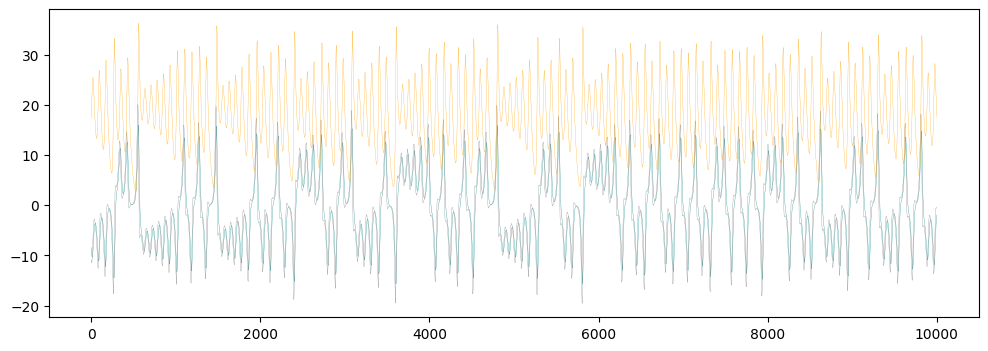

In [58]:
f = plt.plot(xyz_values[n_plot:, 0], lw=0.2, c="teal")
f = plt.plot(xyz_values[n_plot:, 1], lw=0.2, c="gray")
f = plt.plot(xyz_values[n_plot:, 2], lw=0.2, c="orange")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)

#### Outputs

The algorithm produces 

2 Audio/CV Outs
2 CV Outs
2 Pulse Outs

The x and y outputs are quite similar and cross zero unpredictably. The zero-crossings could be used to produce pulses.
Combinations of the outputs may also be useful, or multiple systems running at once with different initial points (OCHD inspired?, split to two like the advent example)
If yu can get it fast enough, could be an audio oscillator?

#### Inputs
Seems obvious to want to control the rate, including down to very slow speeds.
speed could be CV in plus a knob
could also control the magnitude of the CV outputs (scaled to voltage, that is).
Could also be control over the model "constants" if that's useful? how do plots compare for these params?

Pulse inputs could be used to reset with the same initial values so that you can get repeating patterns.

* CV out - the first coordinate of the system
* CV out - the second or third coordinate of the system
* Pulse out - fires when y or z crosses zero
* Knob - scale the first coordinate of the system
* CV in - change beta of the system
* CV in - change sigma of the system
* Pulse in - reset the simulation
* Switch - choose between values of rho

Main knob - control shared rate, one fast one slower tuned like OCHD. Could also package up as a "single-side" for combination with others.

This seems pretty interesting.

Only thing to watch is that the whole thing can reach a state where all inputs go to a global attractor.
Bear in mind also that if you do find a set of parameters and initial state with a single attractor it could be used as an envelope.

the switch might be better off choosing which pair of outputs you want, since there are 3. Or maybe in the one-big-module version

NB: I think there are two version of this thing, one that just gives you two independent sloths (maybe tuned for different ranges) and the below, which seems more fun but maybe overengineered.

NB: For the looper it might be easier to have a pulse input simply reset the simulation, and another to turn looping off?
This may be the answer; one pulse to set start time, another to return to the start, but this leaves Z no job and requires a source of triggers - but that could be the module itself if the loop is crossing zero in x||y.

# Design

The module runs two Lorenz attractors with different rates that are a fixed ratio of each other (0chd)-inspired.
The shared rate is set by the main knob. One attractor's frequency is set directly by the main knob, the other is derived from it by a constant factor (bnut you could make this non-linear for more fun).

The module is loopable, such that the two attractors get sent back to a start point whenever they reach an endpoint (you could also make this more interesting by slightly perturbing the start point each loop so that they slowly diverge).

Each attractor then gets 2 CV outs, one for z and one for either x or y.
Each attractor gets a single pulse out.
* can generate pulses when (x or y) cross zero, corresponding to the trajectory moving to the other lobe.
* can generate pulses on simulation restart, allowing for rythmic timing with modulation. You only need one pulse out for this for both systems though; they share a loop. Could you give them different loop points? No thanks.

Each attractor is also gonna get 2 CV ins and I have no idea what to do with those. CV control of the system parameters seems like breaking the whole concept to me but should I really care? CV control of the rate would be fun.
If you want to be able to get it to do envelopes, you need control over the model so that you can force it into stability.

Each attractor gets a single pulse in.
* when looping, one pulse in can be to set start position (at time t) and one can be to set end position. There will be syncing to deal with here, and potentially the need to make sure the integration doesn't cause the systems to drift such that they never reach the end position. May be better to do this with an integer counter since that is easier and not subject to roundoff in the integration.


X and Y can control system parameters (rho, sigma, beta e.g.) for BOTH systems. Setting limits on these requires a bit of maths. They could also be attenuverters but that feels more boring in a modular environment?

Z will turn looping on (this can be suggested to be Turing machine inspired but binary (looping or not looping). If there were some continuous sense of looping [perhaps by adding some amount of noise to the initial x, y, z] then it could be more Turing-y.

The LEDs should show status. In looping mode they can blink on phrase restart.
